In [1]:
!pip install numpy==1.26.4


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy
numpy.version.version

'1.26.4'

In [3]:
%pip install umap-learn --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

/Users/rwikkamilya/MSc/Intro_DL/intro_dl_ass_0/.venv3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
X_train = pd.read_csv('../../data/train_in.csv', header=None)
y_train = pd.read_csv('../../data/train_out.csv', header=None).values.flatten()

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [7]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train)

In [9]:
umap_model = UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_train)

/Users/rwikkamilya/MSc/Intro_DL/intro_dl_ass_0/.venv3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


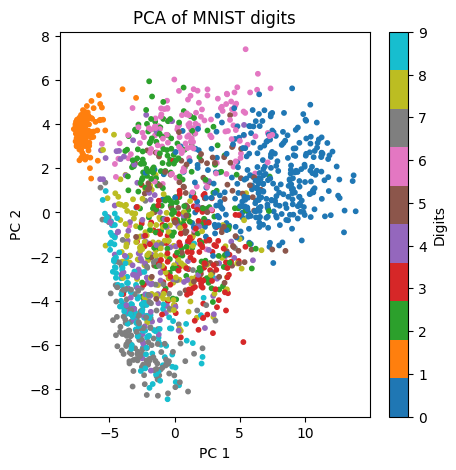

In [16]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=1, s=10)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of MNIST digits')
plt.colorbar(scatter, ticks=range(10), label='Digits')
plt.show()

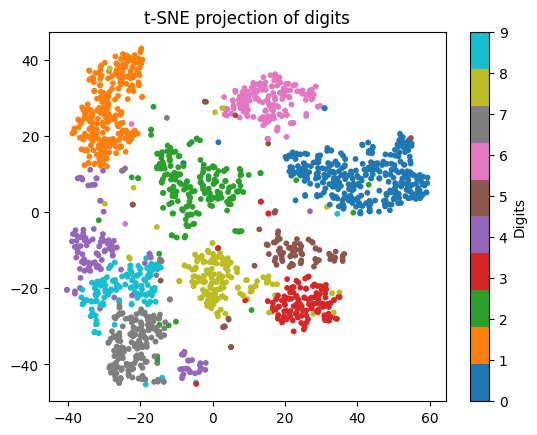

In [11]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='tab10', s=10)
plt.colorbar(ticks=range(10), label='Digits')
plt.title("t-SNE projection of digits")
plt.show()

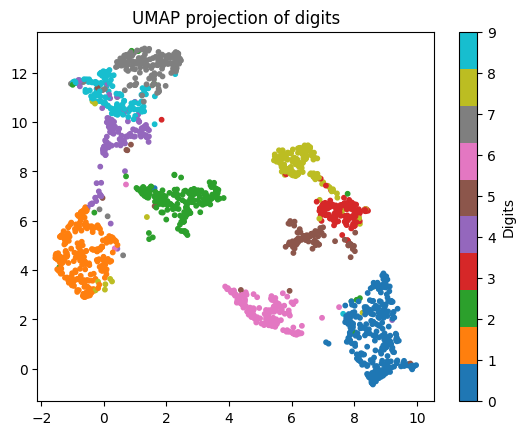

In [12]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap='tab10', s=10)
plt.colorbar(ticks=range(10), label='Digits')
plt.title("UMAP projection of digits")
plt.show()